Task 2:

Loading Pre-Processed Data

In [111]:
import mne
from mne_bids import BIDSPath, read_raw_bids
import pandas as pd
import numpy as np
from pathlib import Path

processed_data_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data'
sub = '12'

# Load preprocessed data for sub
file_path = f'{processed_data_dir}/sub{sub}_preprocessed-raw.fif'
raw = mne.io.read_raw_fif(file_path, preload=True)

# Define BIDS info
bids_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/ds003688'
bids_path = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)

electrodes_path = bids_path.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
electrodes_df = pd.read_csv(electrodes_path.fpath, sep='\t')

pos = {}
for idx, row in electrodes_df.iterrows():
    pos[row['name']] = [row['x'], row['y'], row['z']]

montage = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='mri')
raw.set_montage(montage)

print(f"Raw data shape: {raw.get_data().shape}")
print(f"Number of electrodes loaded: {len(electrodes_df)}")
print(f"Electrode names: {list(electrodes_df['name'])}")

Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub12_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 226269 =      0.000 ...   441.932 secs
Ready.
Reading 0 ... 226269  =      0.000 ...   441.932 secs...
Raw data shape: (64, 226270)
Number of electrodes loaded: 64
Electrode names: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64']


/tmp/ipykernel_14399/1559686668.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Confirming if electrode data has been accurately extracted

In [112]:
electrode_coords = electrodes_df[['name', 'x', 'y', 'z']].set_index('name')

electrode_data = {
    'coords': electrodes_df[['x', 'y', 'z']].values,  
    'names': electrodes_df['name'].values,
    'dataframe': electrode_coords
}

print(f"Coordinate array shape: {electrode_data['coords'].shape}")
print(f"Sample coordinates:\n{electrode_data['coords'][:69]}")
print(f"\nElectrode names: {electrode_data['names']}")

Coordinate array shape: (64, 3)
Sample coordinates:
[[-38.009  76.291  52.286]
 [-43.009  64.291  55.286]
 [-46.009  54.291  57.286]
 [-48.009  45.291  60.286]
 [-50.009  35.291  61.286]
 [-55.009  25.291  64.286]
 [-56.009  14.291  64.286]
 [-55.009   5.291  65.286]
 [-43.009  74.291  44.286]
 [-48.009  64.291  46.286]
 [-51.009  54.291  48.286]
 [-54.009  44.291  50.286]
 [-57.009  34.291  52.286]
 [-59.009  23.291  54.286]
 [-59.009  12.291  56.286]
 [-60.009   2.291  56.286]
 [-49.009  70.291  34.286]
 [-53.009  61.291  35.286]
 [-53.009  50.291  36.286]
 [-55.009  41.291  38.286]
 [-60.009  32.291  41.286]
 [-61.009  21.291  43.286]
 [-63.009  11.291  46.286]
 [-63.009   0.291  47.286]
 [-50.009  67.291  22.286]
 [-52.009  57.291  24.286]
 [-48.009  47.291  24.286]
 [-56.009  39.291  28.286]
 [-60.009  30.291  31.286]
 [-61.009  20.291  33.286]
 [-62.009   9.291  35.286]
 [-62.009  -0.709  36.286]
 [ -3.009  80.291  62.286]
 [ -6.009  73.291  70.286]
 [ -9.009  65.291  75.286]
 [-

Dividing channels into speech and music epochs

In [113]:
# Load events data - specify task and run
events_path = bids_path.copy().update(suffix='events', extension='.tsv', task='film', run=1)
events_path_str = events_path.fpath

events_df = None

if not Path(events_path_str).exists():
    print(f"Events file not found at: {events_path_str}")
    print(f"Listing files in directory: {Path(events_path_str).parent}")
    import os
    if Path(events_path_str).parent.exists():
        print(os.listdir(Path(events_path_str).parent))
else:
    events_df = pd.read_csv(events_path_str, sep='\t')

if events_df is not None:
    print(f"Events shape: {events_df.shape}")
    print(f"Event columns: {events_df.columns.tolist()}")
    print(f"Unique trial types: {events_df['trial_type'].unique()}")
    print(events_df.head(10))

    sfreq = raw.info['sfreq']
    events_df['sample'] = (events_df['onset'] * sfreq).astype(int)

    music_epochs = []
    speech_epochs = []

    for idx, event in events_df.iterrows():
        trial_type = event['trial_type']
        start_sample = event['sample']
        duration_samples = int(event['duration'] * sfreq)
        end_sample = start_sample + duration_samples
        
        # Extract epoch data
        epoch_data = raw.get_data(tmin=event['onset'], tmax=event['onset'] + event['duration'])
        
        if trial_type == 'music':
            music_epochs.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
        elif trial_type == 'speech':
            speech_epochs.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})

    print(f"\nMusic epochs: {len(music_epochs)}")
    print(f"Speech epochs: {len(speech_epochs)}")
else:
    print("Warning: Events data could not be loaded")

Events shape: (15, 4)
Event columns: ['onset', 'duration', 'trial_type', 'value']
Unique trial types: ['start task' 'music' 'speech' 'end task']
     onset  duration  trial_type  value
0   42.820     0.000  start task      9
1   42.830    30.001       music      2
2   72.831    30.003      speech      1
3  102.834    30.002       music      2
4  132.836    30.003      speech      1
5  162.839    30.004       music      2
6  192.843    30.001      speech      1
7  222.844    30.003       music      2
8  252.847    30.003      speech      1
9  282.850    30.002       music      2

Music epochs: 7
Speech epochs: 6


Plotting the speech and music epochs for 1 channel

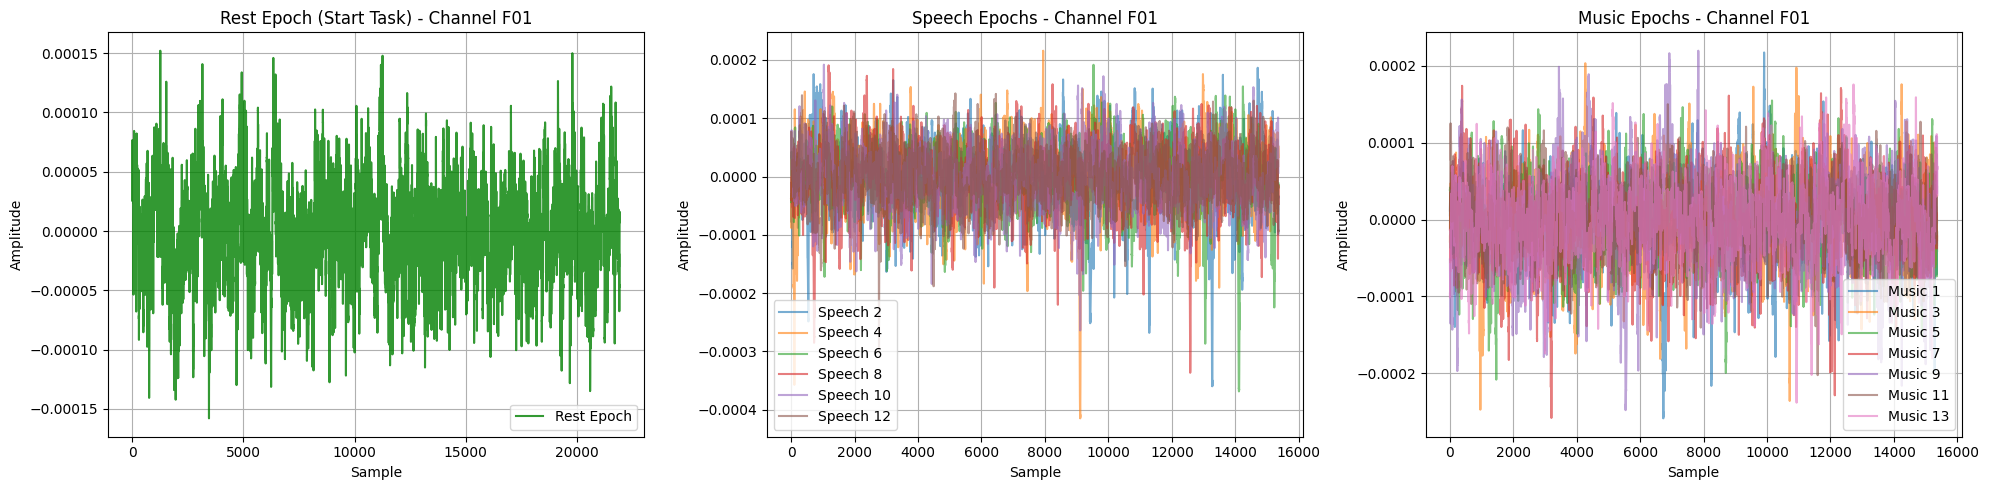

In [114]:
import matplotlib.pyplot as plt

channel_idx = 0
channel_name = electrode_data['names'][channel_idx]

# Extract rest/start task data (before first event)
first_event_onset = events_df['onset'].min()
rest_duration = min(first_event_onset, 60)
rest_data = raw.get_data(tmin=0, tmax=rest_duration)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Rest/Start Task Epoch
ax0 = axes[0]
ax0.plot(rest_data[channel_idx], alpha=0.8, color='green', label='Rest Epoch')
ax0.set_title(f'Rest Epoch (Start Task) - Channel {channel_name}')
ax0.set_xlabel('Sample')
ax0.set_ylabel('Amplitude')
ax0.legend()
ax0.grid(True)

# Speech Epochs
ax1 = axes[1]
for epoch in speech_epochs:
    ax1.plot(epoch['data'][channel_idx], alpha=0.6, label=f"Speech {epoch['index']}")
ax1.set_title(f'Speech Epochs - Channel {channel_name}')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# Music Epochs
ax2 = axes[2]
for epoch in music_epochs:
    ax2.plot(epoch['data'][channel_idx], alpha=0.6, label=f"Music {epoch['index']}")
ax2.set_title(f'Music Epochs - Channel {channel_name}')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Plotting the PSD's for all music and speech epochs of 1 particular channel

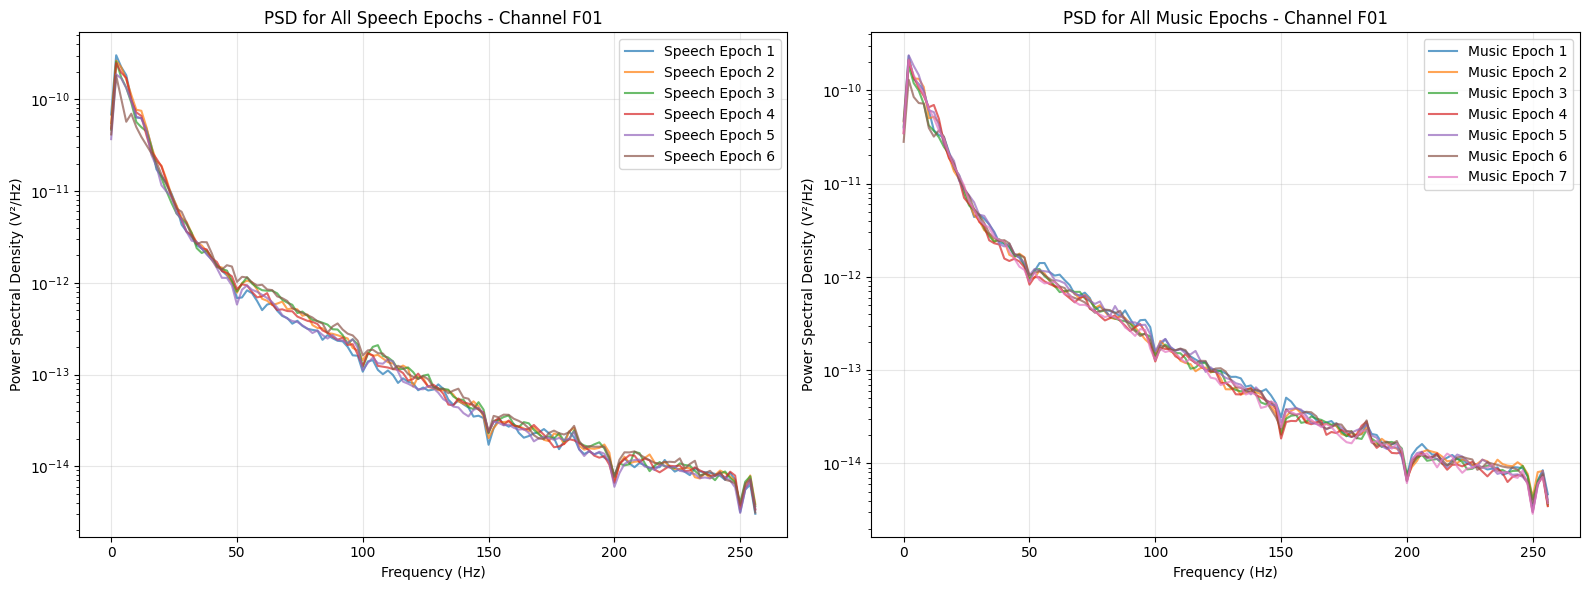

In [115]:
from scipy import signal

# Calculate PSD for each epoch individually
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot PSD for all speech epochs
ax_speech = axes[0]
for i, epoch in enumerate(speech_epochs):
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    ax_speech.semilogy(f, psd, alpha=0.7, linewidth=1.5, label=f"Speech Epoch {i+1}")
ax_speech.set_title(f'PSD for All Speech Epochs - Channel {channel_name}')
ax_speech.set_xlabel('Frequency (Hz)')
ax_speech.set_ylabel('Power Spectral Density (V²/Hz)')
ax_speech.grid(True, alpha=0.3)
ax_speech.legend()

# Plot PSD for all music epochs
ax_music = axes[1]
for i, epoch in enumerate(music_epochs):
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    ax_music.semilogy(f, psd, alpha=0.7, linewidth=1.5, label=f"Music Epoch {i+1}")
ax_music.set_title(f'PSD for All Music Epochs - Channel {channel_name}')
ax_music.set_xlabel('Frequency (Hz)')
ax_music.set_ylabel('Power Spectral Density (V²/Hz)')
ax_music.grid(True, alpha=0.3)
ax_music.legend()

plt.tight_layout()
plt.show()

Plotting the average PSD for all speech and music epochs in a particular channel

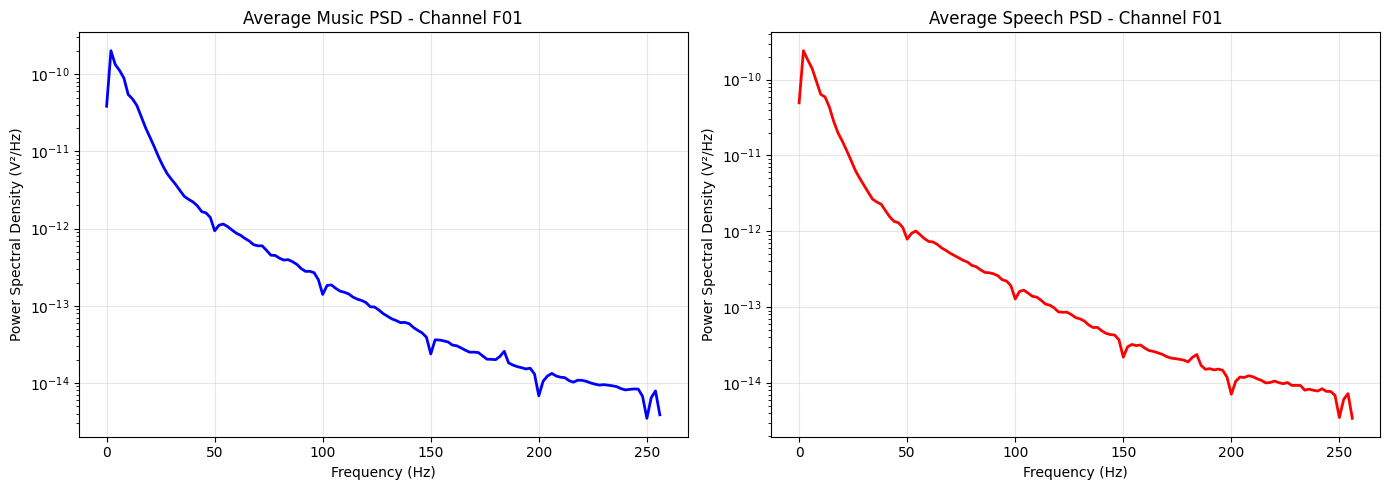

In [116]:
from scipy import signal


music_psd_list = []
speech_psd_list = []

for epoch in music_epochs:
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    music_psd_list.append(psd)

for epoch in speech_epochs:
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    speech_psd_list.append(psd)

# Calculate average PSD for music and speech epochs
music_psd_avg = np.mean(music_psd_list, axis=0)
speech_psd_avg = np.mean(speech_psd_list, axis=0)

# Create figure with 2 subplots for average PSDs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot average music PSD
axes[0].semilogy(f, music_psd_avg, linewidth=2, color='blue')
axes[0].set_title(f'Average Music PSD - Channel {channel_name}')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].grid(True, alpha=0.3)

# Plot average speech PSD
axes[1].semilogy(f, speech_psd_avg, linewidth=2, color='red')
axes[1].set_title(f'Average Speech PSD - Channel {channel_name}')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Processing all channels would be computationally expensive. Hence we filter out only the electrodes situated near regions of the brain which processes music and speech and only analyze them. This includes : "HG", "ST", "sT","H", "PT", "ST", "A", "AHL", "AHR", "T", "TOL", "ITR", "vT", "MFL", "MFR", "F"

In [117]:
# Filter electrodes to auditory regions based on coordinates and nomenclature
def get_auditory_picks(raw, electrodes_df):
    """
    Filters channels based on anatomical coordinates and nomenclature.
    Target: Temporal lobe (STG/Auditory cortex)
    """
    available_channels = raw.ch_names
    target_df = electrodes_df[electrodes_df['name'].isin(available_channels)]
    
    auditory_picks = []
    for _, row in target_df.iterrows():
        name = row["name"]
        x, y, z = row["x"], row["y"], row["z"]
        
        # Coordinate-based logic: Temporal lobe region
        is_in_auditory_space = (
            abs(x) >= 35 and 
            -20 <= y <= 20 and 
            -10 <= z <= 25
        )
        
        # Nomenclature-based logic: Auditory-related electrode names
        is_named_auditory = name.startswith(("HG", "ST", "sT","H", "PT", "ST", "A", "AHL", "AHR", "T", "TOL", "ITR", "vT", "MFL", "MFR", "F"))
        
        if is_in_auditory_space or (is_named_auditory and abs(x) >= 30):
            auditory_picks.append(name)
    
    return auditory_picks

# Get auditory channels
auditory_channels = get_auditory_picks(raw, electrodes_df)
raw_auditory = raw.copy().pick_channels(auditory_channels)

print(f"Total auditory electrodes selected: {len(auditory_channels)}")
print(f"Selected contacts: {auditory_channels}")

# Update electrode_data for auditory channels only
auditory_indices = [i for i, name in enumerate(electrode_data['names']) if name in auditory_channels]
electrode_data_auditory = {
    'coords': electrode_data['coords'][auditory_indices],
    'names': electrode_data['names'][auditory_indices],
    'dataframe': electrode_coords.loc[auditory_channels]
}

print(f"Auditory electrode data updated: {len(auditory_indices)} channels")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Total auditory electrodes selected: 47
Selected contacts: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64']
Auditory electrode data updated: 47 channels


Calculating the Average PSD for all speech epochs and music epochs for all auditory channel and plotting them separately

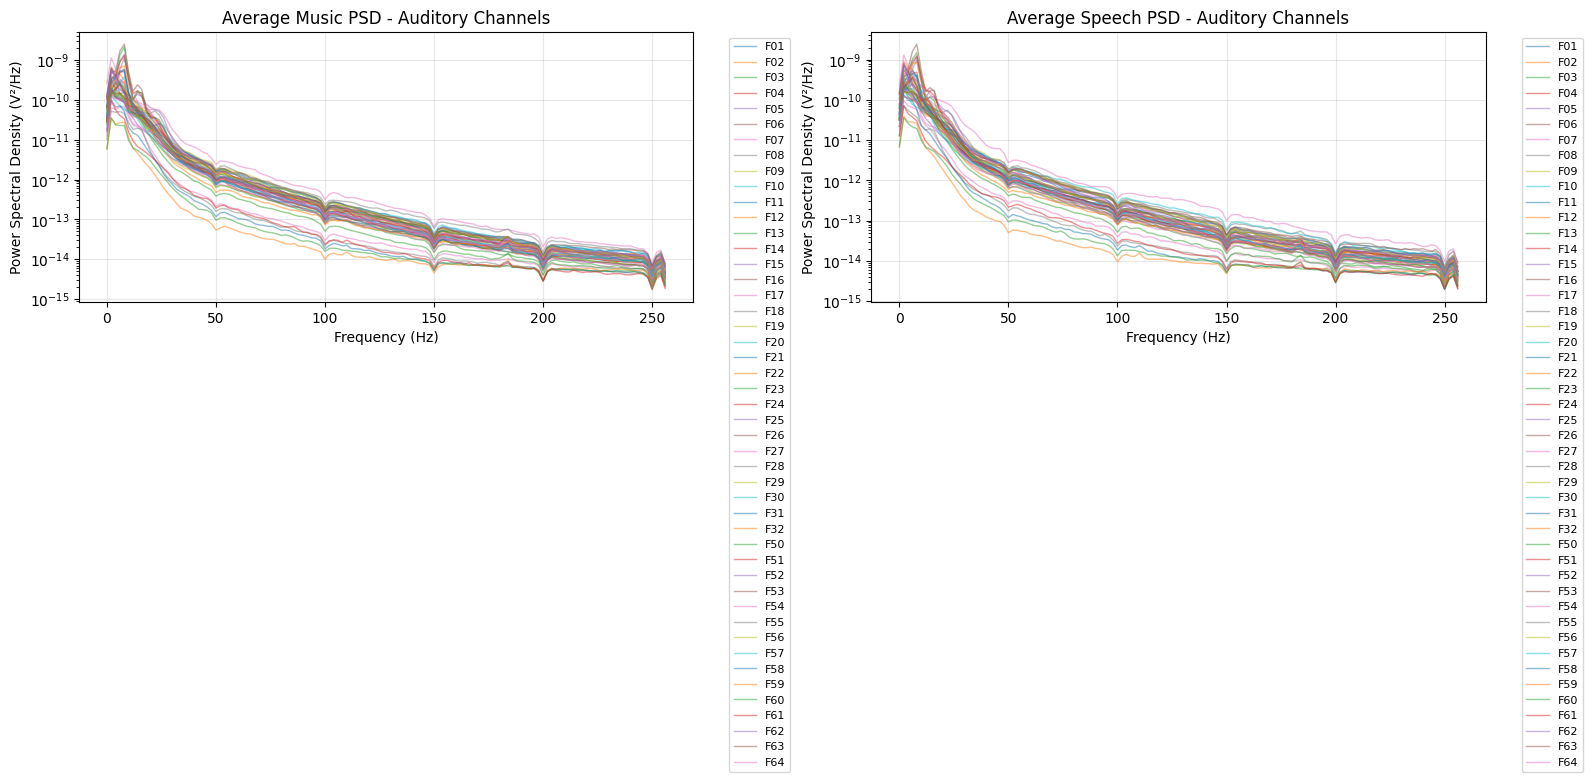

In [118]:
# Calculate average PSD for auditory channels only (music and speech)
music_psd_auditory = []
speech_psd_auditory = []

for ch_idx in auditory_indices:
    music_psd_ch = []
    speech_psd_ch = []
    
    for epoch in music_epochs:
        ch_name = electrode_data['names'][ch_idx]
        if ch_name in raw.ch_names:
            epoch_ch_idx = raw.ch_names.index(ch_name)
            f, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq)
        else:
            continue
        music_psd_ch.append(psd)
    
    for epoch in speech_epochs:
        ch_name = electrode_data['names'][ch_idx]
        if ch_name in raw.ch_names:
            epoch_ch_idx = raw.ch_names.index(ch_name)
            f, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq)
        else:
            continue
        speech_psd_ch.append(psd)
    
    music_psd_auditory.append(np.mean(music_psd_ch, axis=0))
    speech_psd_auditory.append(np.mean(speech_psd_ch, axis=0))

# Convert to arrays for easier handling
music_psd_auditory = np.array(music_psd_auditory)
speech_psd_auditory = np.array(speech_psd_auditory)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot average music PSD for auditory channels
ax_music = axes[0]
for i, ch_idx in enumerate(auditory_indices):
    ax_music.semilogy(f, music_psd_auditory[i], alpha=0.5, linewidth=1, label=electrode_data['names'][ch_idx])
ax_music.set_title('Average Music PSD - Auditory Channels')
ax_music.set_xlabel('Frequency (Hz)')
ax_music.set_ylabel('Power Spectral Density (V²/Hz)')
ax_music.grid(True, alpha=0.3)
ax_music.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot average speech PSD for auditory channels
ax_speech = axes[1]
for i, ch_idx in enumerate(auditory_indices):
    ax_speech.semilogy(f, speech_psd_auditory[i], alpha=0.5, linewidth=1, label=electrode_data['names'][ch_idx])
ax_speech.set_title('Average Speech PSD - Auditory Channels')
ax_speech.set_xlabel('Frequency (Hz)')
ax_speech.set_ylabel('Power Spectral Density (V²/Hz)')
ax_speech.grid(True, alpha=0.3)
ax_speech.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

Average PSD of speech and music over all signals

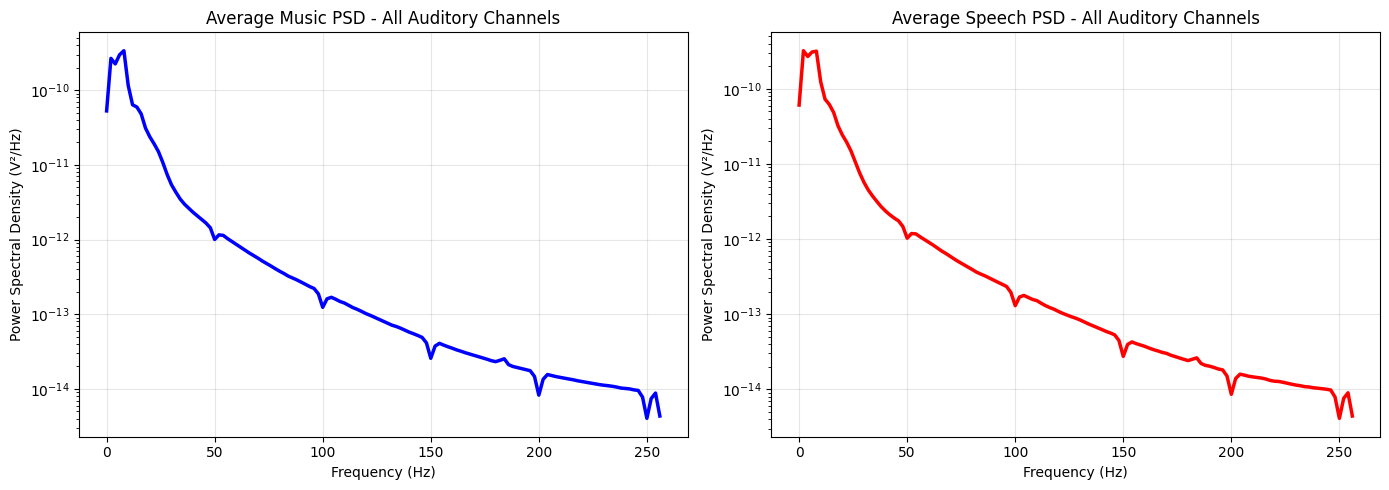

In [119]:
# Calculate average PSD across all auditory channels for music and speech
music_psd_avg_auditory = np.mean(music_psd_auditory, axis=0)
speech_psd_avg_auditory = np.mean(speech_psd_auditory, axis=0)

# Create figure with 2 subplots for average PSDs across auditory channels
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot average music PSD across auditory channels
axes[0].semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue')
axes[0].set_title('Average Music PSD - All Auditory Channels')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].grid(True, alpha=0.3)

# Plot average speech PSD across auditory channels
axes[1].semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red')
axes[1].set_title('Average Speech PSD - All Auditory Channels')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Comparing Rest Data which is provided in a separate .eeg file to show natural brain activity to help with comparison and analysis of affect of music and speech

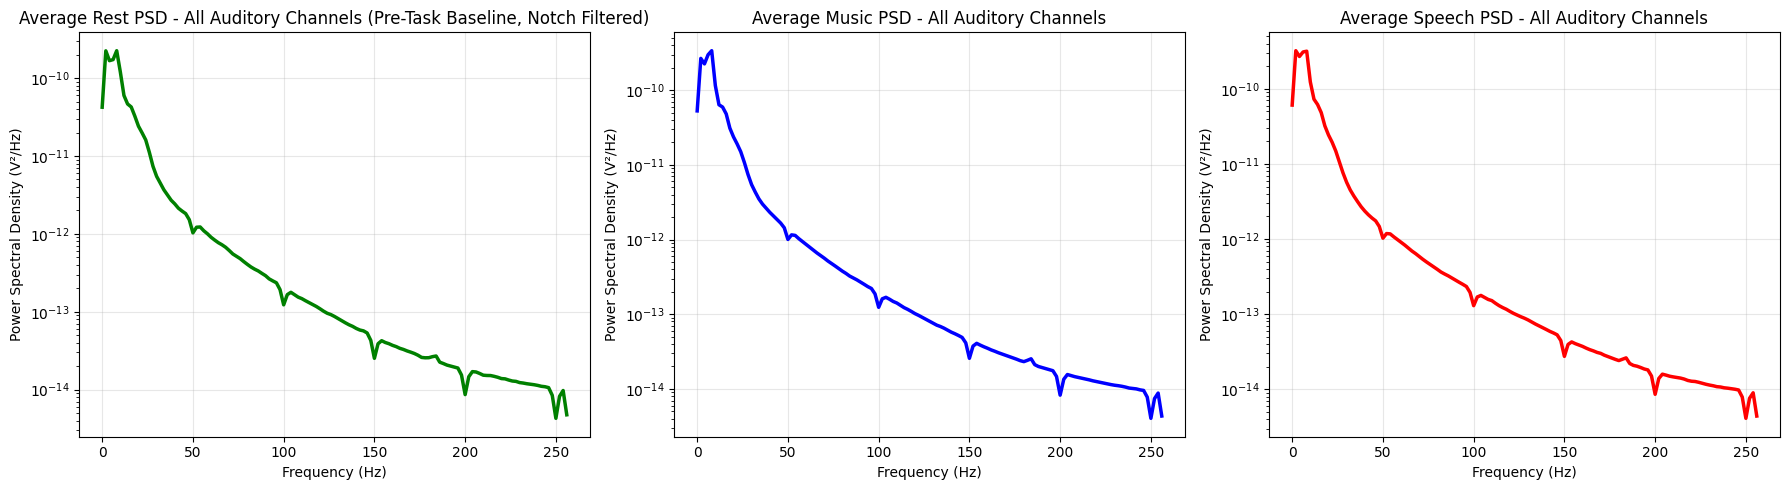

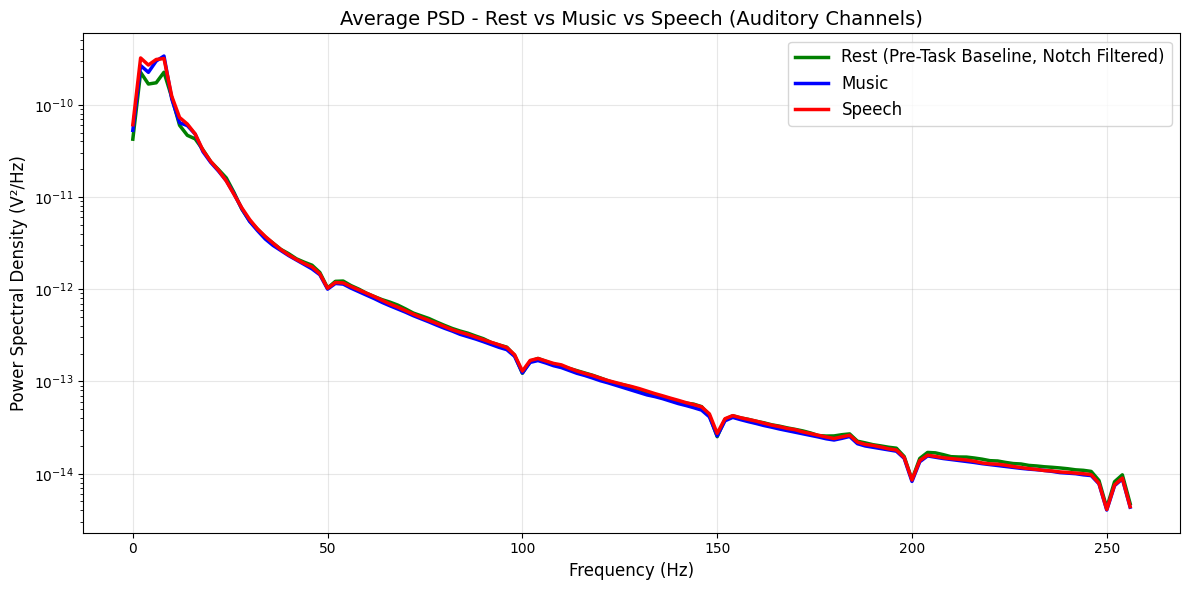

Rest baseline duration: 42.82 seconds


In [120]:
# Extract rest data from film task (pre-task baseline)

# Use the period before the first event as rest data



# Get the first event onset time

first_event_onset = events_df['onset'].min()



# Extract rest data from the beginning until first event (baseline period)

rest_duration = min(first_event_onset, 60)  # Use up to 60 seconds of baseline

rest_raw_film = raw.copy().crop(tmin=0, tmax=rest_duration)



freqs_to_notch = [50, 100, 150, 200, 250]



# Apply notch filter to remove line noise at 50 Hz and harmonics

rest_raw_filtered = rest_raw_film.copy().notch_filter(freqs=freqs_to_notch, verbose=False)

 

# Calculate PSD for rest state across all auditory channels (optimized)

rest_psd_auditory = []

for ch_idx in auditory_indices:

    ch_name = electrode_data['names'][ch_idx]

    if ch_name in rest_raw_filtered.ch_names:

        epoch_ch_idx = rest_raw_filtered.ch_names.index(ch_name)

        f, psd = signal.welch(rest_raw_filtered.get_data()[epoch_ch_idx], sfreq)

        rest_psd_auditory.append(psd)



rest_psd_auditory = np.array(rest_psd_auditory)

rest_psd_avg_auditory = np.mean(rest_psd_auditory, axis=0)



# Create figure comparing rest, music, and speech

fig, axes = plt.subplots(1, 3, figsize=(18, 5))



axes[0].semilogy(f, rest_psd_avg_auditory, linewidth=2.5, color='green')

axes[0].set_title('Average Rest PSD - All Auditory Channels (Pre-Task Baseline, Notch Filtered)')

axes[0].set_xlabel('Frequency (Hz)')

axes[0].set_ylabel('Power Spectral Density (V²/Hz)')

axes[0].grid(True, alpha=0.3)



axes[1].semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue')

axes[1].set_title('Average Music PSD - All Auditory Channels')

axes[1].set_xlabel('Frequency (Hz)')

axes[1].set_ylabel('Power Spectral Density (V²/Hz)')

axes[1].grid(True, alpha=0.3)



axes[2].semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red')

axes[2].set_title('Average Speech PSD - All Auditory Channels')

axes[2].set_xlabel('Frequency (Hz)')

axes[2].set_ylabel('Power Spectral Density (V²/Hz)')

axes[2].grid(True, alpha=0.3)



plt.tight_layout()

plt.show()



# Create overlapping plot with all three conditions

fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogy(f, rest_psd_avg_auditory, linewidth=2.5, color='green', label='Rest (Pre-Task Baseline, Notch Filtered)')

ax.semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue', label='Music')

ax.semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red', label='Speech')

ax.set_title('Average PSD - Rest vs Music vs Speech (Auditory Channels)', fontsize=14)

ax.set_xlabel('Frequency (Hz)', fontsize=12)

ax.set_ylabel('Power Spectral Density (V²/Hz)', fontsize=12)

ax.grid(True, alpha=0.3)

ax.legend(fontsize=12)

plt.tight_layout()

plt.show()



print(f"Rest baseline duration: {rest_duration:.2f} seconds")

/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


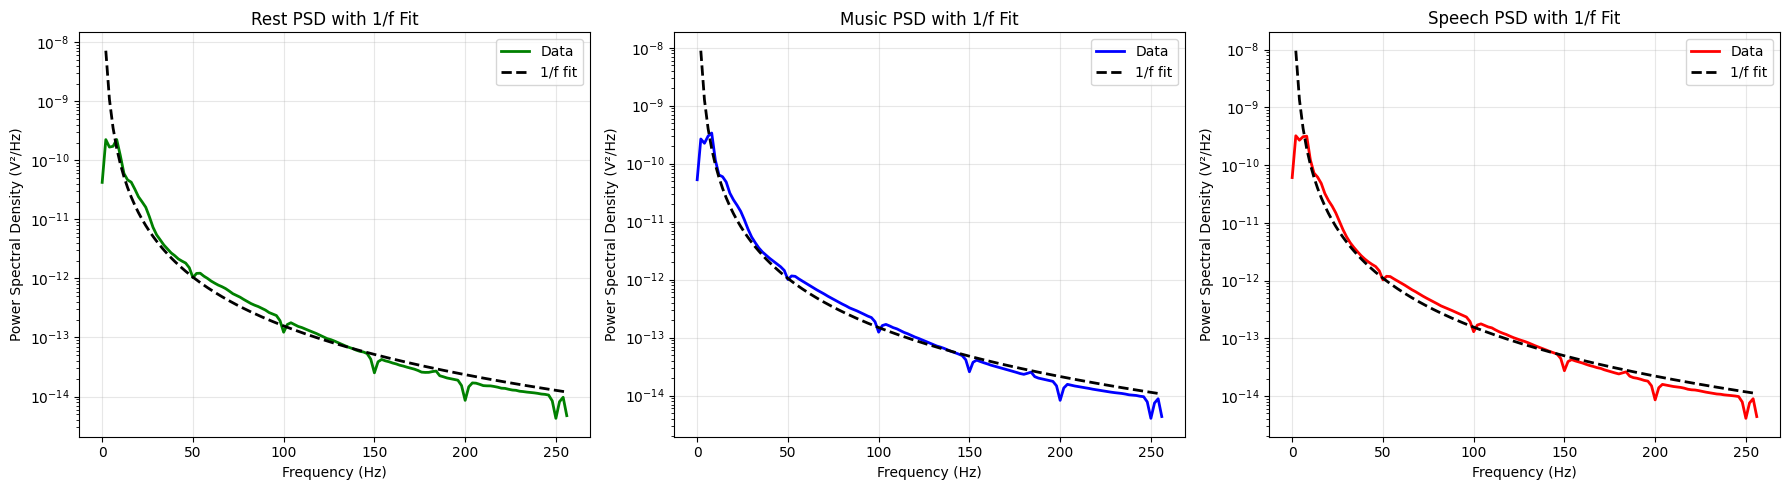

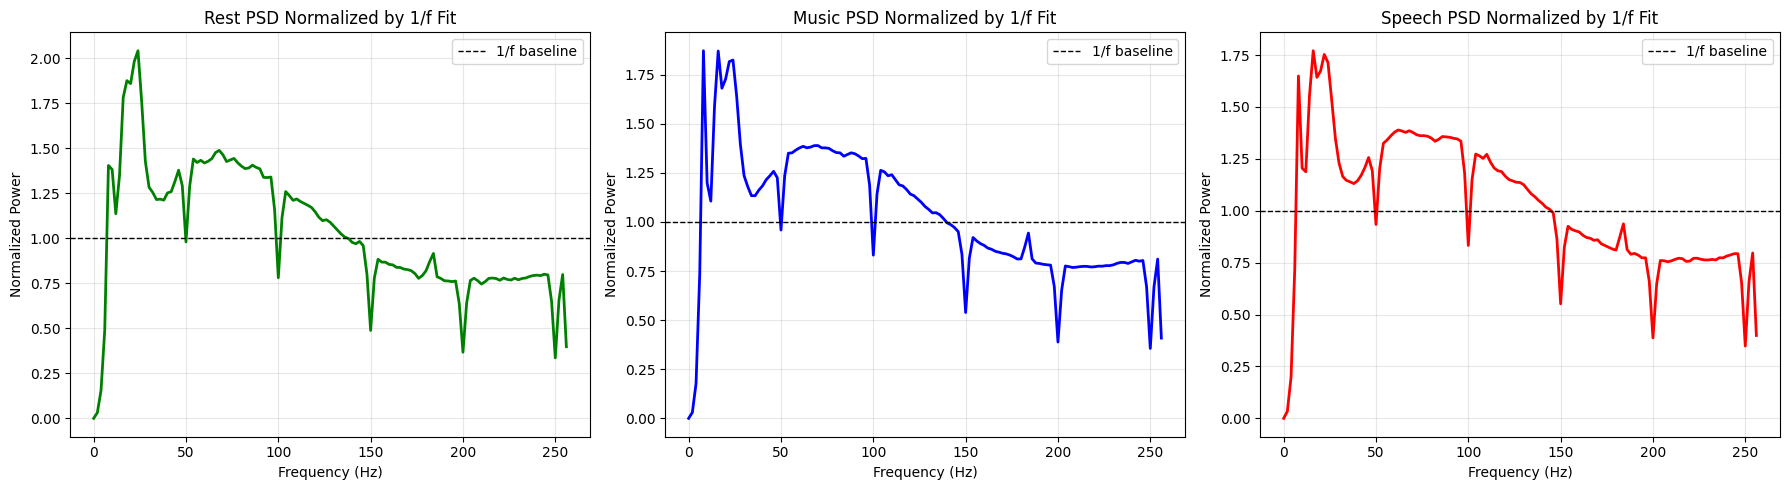

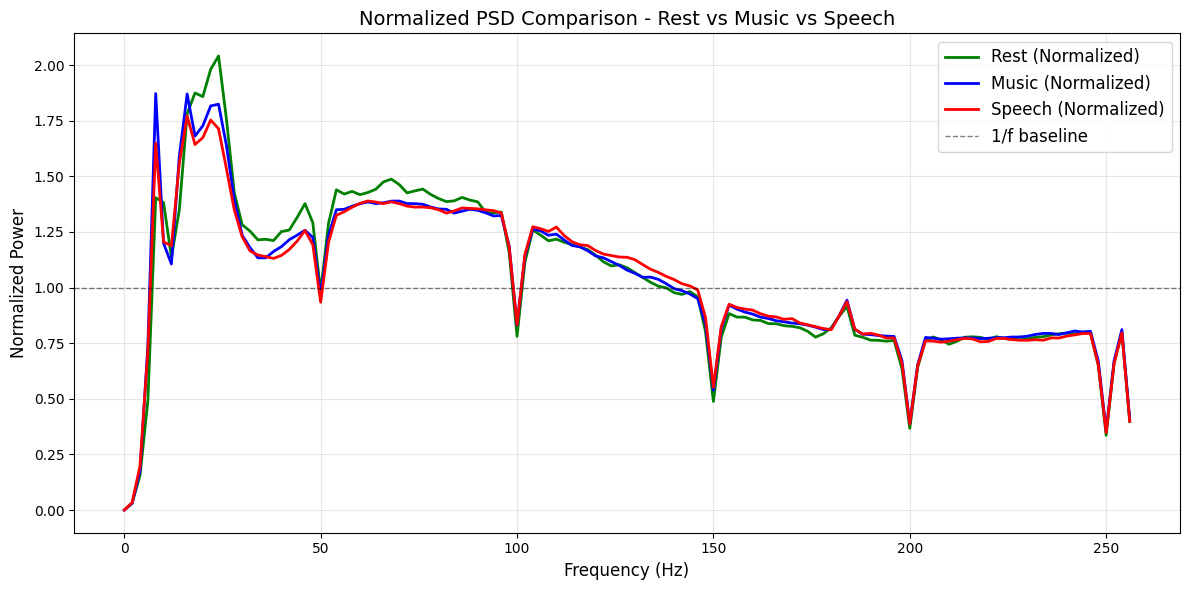

In [121]:
from scipy.optimize import curve_fit

def fit_1overf_robust(freqs, psd, freq_range=(1, 250)):
    """Fits 1/f while ignoring line noise harmonics."""
    if len(freqs) != len(psd):
        raise ValueError(f"Shape mismatch: freqs has {len(freqs)} elements, "
                         f"but psd has {len(psd)} elements.")

    mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    
    # Ignore 2Hz on either side of each harmonic
    for harmonic in [50, 100, 150, 200, 250]:
        mask &= ~((freqs > harmonic - 2) & (freqs < harmonic + 2))
    
    freqs_fit = freqs[mask]
    psd_fit = psd[mask]
    
    def log_model(f, a, b):
        return np.log10(a) - b * np.log10(f)
    
    popt, _ = curve_fit(log_model, freqs_fit, np.log10(psd_fit))
    
    return 10 ** (log_model(freqs, *popt))

# Calculate frequency arrays that match each PSD's shape
f_music, _ = signal.welch(music_epochs[0]['data'][0], sfreq)
f_speech, _ = signal.welch(speech_epochs[0]['data'][0], sfreq)
f_rest, _ = signal.welch(rest_raw_filtered.get_data()[0], sfreq)

# Calculate fits with matching frequency arrays
rest_1overf = fit_1overf_robust(f_rest, rest_psd_avg_auditory, freq_range=(1, 250))
music_1overf = fit_1overf_robust(f_music, music_psd_avg_auditory, freq_range=(1, 250))
speech_1overf = fit_1overf_robust(f_speech, speech_psd_avg_auditory, freq_range=(1, 250))

# Plot the results with 1/f fits
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rest
axes[0].semilogy(f_rest, rest_psd_avg_auditory, linewidth=2, color='green', label='Data')
axes[0].semilogy(f_rest, rest_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[0].set_title('Rest PSD with 1/f Fit')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Music
axes[1].semilogy(f_music, music_psd_avg_auditory, linewidth=2, color='blue', label='Data')
axes[1].semilogy(f_music, music_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[1].set_title('Music PSD with 1/f Fit')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Speech
axes[2].semilogy(f_speech, speech_psd_avg_auditory, linewidth=2, color='red', label='Data')
axes[2].semilogy(f_speech, speech_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[2].set_title('Speech PSD with 1/f Fit')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Power Spectral Density (V²/Hz)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate normalized PSDs by dividing by 1/f fit
rest_psd_normalized = rest_psd_avg_auditory / rest_1overf
music_psd_normalized = music_psd_avg_auditory / music_1overf
speech_psd_normalized = speech_psd_avg_auditory / speech_1overf

# Plot normalized PSDs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Normalized Rest
axes[0].plot(f_rest, rest_psd_normalized, linewidth=2, color='green')
axes[0].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[0].set_title('Rest PSD Normalized by 1/f Fit')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Normalized Power')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalized Music
axes[1].plot(f_music, music_psd_normalized, linewidth=2, color='blue')
axes[1].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[1].set_title('Music PSD Normalized by 1/f Fit')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Power')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Normalized Speech
axes[2].plot(f_speech, speech_psd_normalized, linewidth=2, color='red')
axes[2].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[2].set_title('Speech PSD Normalized by 1/f Fit')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Normalized Power')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overlay all normalized PSDs for comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(f_rest, rest_psd_normalized, linewidth=2, color='green', label='Rest (Normalized)')
ax.plot(f_music, music_psd_normalized, linewidth=2, color='blue', label='Music (Normalized)')
ax.plot(f_speech, speech_psd_normalized, linewidth=2, color='red', label='Speech (Normalized)')
ax.axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
ax.set_title('Normalized PSD Comparison - Rest vs Music vs Speech', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Normalized Power', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [137]:
import pickle
import os
from pathlib import Path
import glob

# Define processed data directory (update path as needed)
processed_data_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data'
bids_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/ds003688'

# Dictionary to store normalized PSD data for multiple subjects
subjects_psd_data = {}

# List of subjects to process
subject_list = ['02', '05', '06', '07', '09', '12']

for sub_id in subject_list:
    print(f"\nProcessing Subject {sub_id}...")
    
    try:
        # Load preprocessed data
        file_path_sub = f'{processed_data_dir}/sub{sub_id}_preprocessed-raw.fif'
        raw_sub = mne.io.read_raw_fif(file_path_sub, preload=True)
        
        # Load electrodes data
        bids_path_sub = BIDSPath(subject=sub_id, session='iemu', datatype='ieeg', root=bids_dir)
        electrodes_path_sub = bids_path_sub.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
        electrodes_df_sub = pd.read_csv(electrodes_path_sub.fpath, sep='\t')
        
        # Create and set montage
        pos_sub = {row['name']: [row['x'], row['y'], row['z']] for _, row in electrodes_df_sub.iterrows()}
        montage_sub = mne.channels.make_dig_montage(ch_pos=pos_sub, coord_frame='mri')
        raw_sub.set_montage(montage_sub)
        
        # Find events file using glob pattern
        events_df_sub = None
        events_pattern = os.path.join(bids_dir, f'sub-{sub_id}', 'ses-iemu', 'ieeg', 
                                      f'sub-{sub_id}_ses-iemu_task-film_run-*_events.tsv')
        events_files = glob.glob(events_pattern)
        
        if events_files:
            # Use the first matching file
            events_file = events_files[0]
            events_df_sub = pd.read_csv(events_file, sep='\t')
            run_num = os.path.basename(events_file).split('run-')[1].split('_')[0]
            print(f"  Found events file with run={run_num}")
        else:
            raise FileNotFoundError(f"No events file found for subject {sub_id}")
        
        sfreq_sub = raw_sub.info['sfreq']
        events_df_sub['sample'] = (events_df_sub['onset'] * sfreq_sub).astype(int)
        
        # Extract epochs
        music_epochs_sub = []
        speech_epochs_sub = []
        for idx, event in events_df_sub.iterrows():
            epoch_data = raw_sub.get_data(tmin=event['onset'], tmax=event['onset'] + event['duration'])
            if event['trial_type'] == 'music':
                music_epochs_sub.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
            elif event['trial_type'] == 'speech':
                speech_epochs_sub.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
        
        # Get auditory channels
        auditory_channels_sub = get_auditory_picks(raw_sub, electrodes_df_sub)
        electrode_coords_sub = electrodes_df_sub[['name', 'x', 'y', 'z']].set_index('name')
        electrode_data_sub = {
            'coords': electrodes_df_sub[['x', 'y', 'z']].values,
            'names': electrodes_df_sub['name'].values,
            'dataframe': electrode_coords_sub
        }
        auditory_indices_sub = [i for i, name in enumerate(electrode_data_sub['names']) if name in auditory_channels_sub]
        
        # Extract and filter rest data
        first_event_onset_sub = events_df_sub['onset'].min()
        rest_duration_sub = min(first_event_onset_sub, 60)
        rest_raw_sub = raw_sub.copy().crop(tmin=0, tmax=rest_duration_sub)
        rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)
        
        # Calculate PSDs
        music_psd_sub = []
        speech_psd_sub = []
        rest_psd_sub = []
        
        for ch_idx in auditory_indices_sub:
            ch_name = electrode_data_sub['names'][ch_idx]
            
            # Music PSD
            music_psd_ch = []
            for epoch in music_epochs_sub:
                if ch_name in raw_sub.ch_names:
                    epoch_ch_idx = raw_sub.ch_names.index(ch_name)
                    f_sub, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq_sub)
                    music_psd_ch.append(psd)
            if music_psd_ch:
                music_psd_sub.append(np.mean(music_psd_ch, axis=0))
            
            # Speech PSD
            speech_psd_ch = []
            for epoch in speech_epochs_sub:
                if ch_name in raw_sub.ch_names:
                    epoch_ch_idx = raw_sub.ch_names.index(ch_name)
                    f_sub, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq_sub)
                    speech_psd_ch.append(psd)
            if speech_psd_ch:
                speech_psd_sub.append(np.mean(speech_psd_ch, axis=0))
            
            # Rest PSD
            if ch_name in rest_raw_filtered_sub.ch_names:
                epoch_ch_idx = rest_raw_filtered_sub.ch_names.index(ch_name)
                f_sub, psd = signal.welch(rest_raw_filtered_sub.get_data()[epoch_ch_idx], sfreq_sub)
                rest_psd_sub.append(psd)
        
        # Average across channels
        music_psd_avg_sub = np.mean(music_psd_sub, axis=0)
        speech_psd_avg_sub = np.mean(speech_psd_sub, axis=0)
        rest_psd_avg_sub = np.mean(rest_psd_sub, axis=0)
        
        # Fit 1/f and normalize
        rest_1overf_sub = fit_1overf_robust(f_sub, rest_psd_avg_sub, freq_range=(1, 250))
        music_1overf_sub = fit_1overf_robust(f_sub, music_psd_avg_sub, freq_range=(1, 250))
        speech_1overf_sub = fit_1overf_robust(f_sub, speech_psd_avg_sub, freq_range=(1, 250))
        
        rest_psd_normalized_sub = rest_psd_avg_sub / rest_1overf_sub
        music_psd_normalized_sub = music_psd_avg_sub / music_1overf_sub
        speech_psd_normalized_sub = speech_psd_avg_sub / speech_1overf_sub
        
        # Store data
        subjects_psd_data[sub_id] = {
            'frequencies': f_sub,
            'rest_psd_raw': rest_psd_avg_sub,
            'music_psd_raw': music_psd_avg_sub,
            'speech_psd_raw': speech_psd_avg_sub,
            'rest_1overf': rest_1overf_sub,
            'music_1overf': music_1overf_sub,
            'speech_1overf': speech_1overf_sub,
            'rest_psd_normalized': rest_psd_normalized_sub,
            'music_psd_normalized': music_psd_normalized_sub,
            'speech_psd_normalized': speech_psd_normalized_sub,
            'auditory_channels': auditory_channels_sub,
            'n_music_epochs': len(music_epochs_sub),
            'n_speech_epochs': len(speech_epochs_sub)
        }
        
        print(f"✓ Subject {sub_id}: {len(auditory_channels_sub)} auditory channels, "
              f"{len(music_epochs_sub)} music epochs, {len(speech_epochs_sub)} speech epochs")
        
    except Exception as e:
        print(f"✗ Error processing Subject {sub_id}: {str(e)}")

# Save data to disk
os.makedirs(processed_data_dir, exist_ok=True)

output_path = f'{processed_data_dir}/normalized_psd_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(subjects_psd_data, f)

print(f"\n✓ Data saved to: {output_path}")
print(f"Total subjects processed: {len(subjects_psd_data)}")


Processing Subject 02...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub02_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 291997 =      0.000 ...   570.307 secs
Ready.
Reading 0 ... 291997  =      0.000 ...   570.307 secs...


/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 02: 36 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 05...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub05_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 270829 =      0.000 ...   528.963 secs
Ready.
Reading 0 ... 270829  =      0.000 ...   528.963 secs...


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 05: 39 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 06...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub06_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 203145 =      0.000 ...   396.768 secs
Ready.
Reading 0 ... 203145  =      0.000 ...   396.768 secs...


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1


/tmp/ipykernel_14399/2393633399.py:76: RuntimeWarning: filter_length (3381) is longer than the signal (2705), distortion is likely. Reduce filter length or filter a longer signal.
  rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)


✓ Subject 06: 52 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 07...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub07_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 219614 =      0.000 ...   428.934 secs
Ready.
Reading 0 ... 219614  =      0.000 ...   428.934 secs...


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 07: 10 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 09...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub09_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 214220 =      0.000 ...   418.398 secs
Ready.
Reading 0 ... 214220  =      0.000 ...   418.398 secs...


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=2
✓ Subject 09: 24 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 12...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub12_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 226269 =      0.000 ...   441.932 secs
Ready.
Reading 0 ... 226269  =      0.000 ...   441.932 secs...


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/2393633399.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 12: 47 auditory channels, 7 music epochs, 6 speech epochs

✓ Data saved to: /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/normalized_psd_data.pkl
Total subjects processed: 6


/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_14399/4157051797.py:19: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


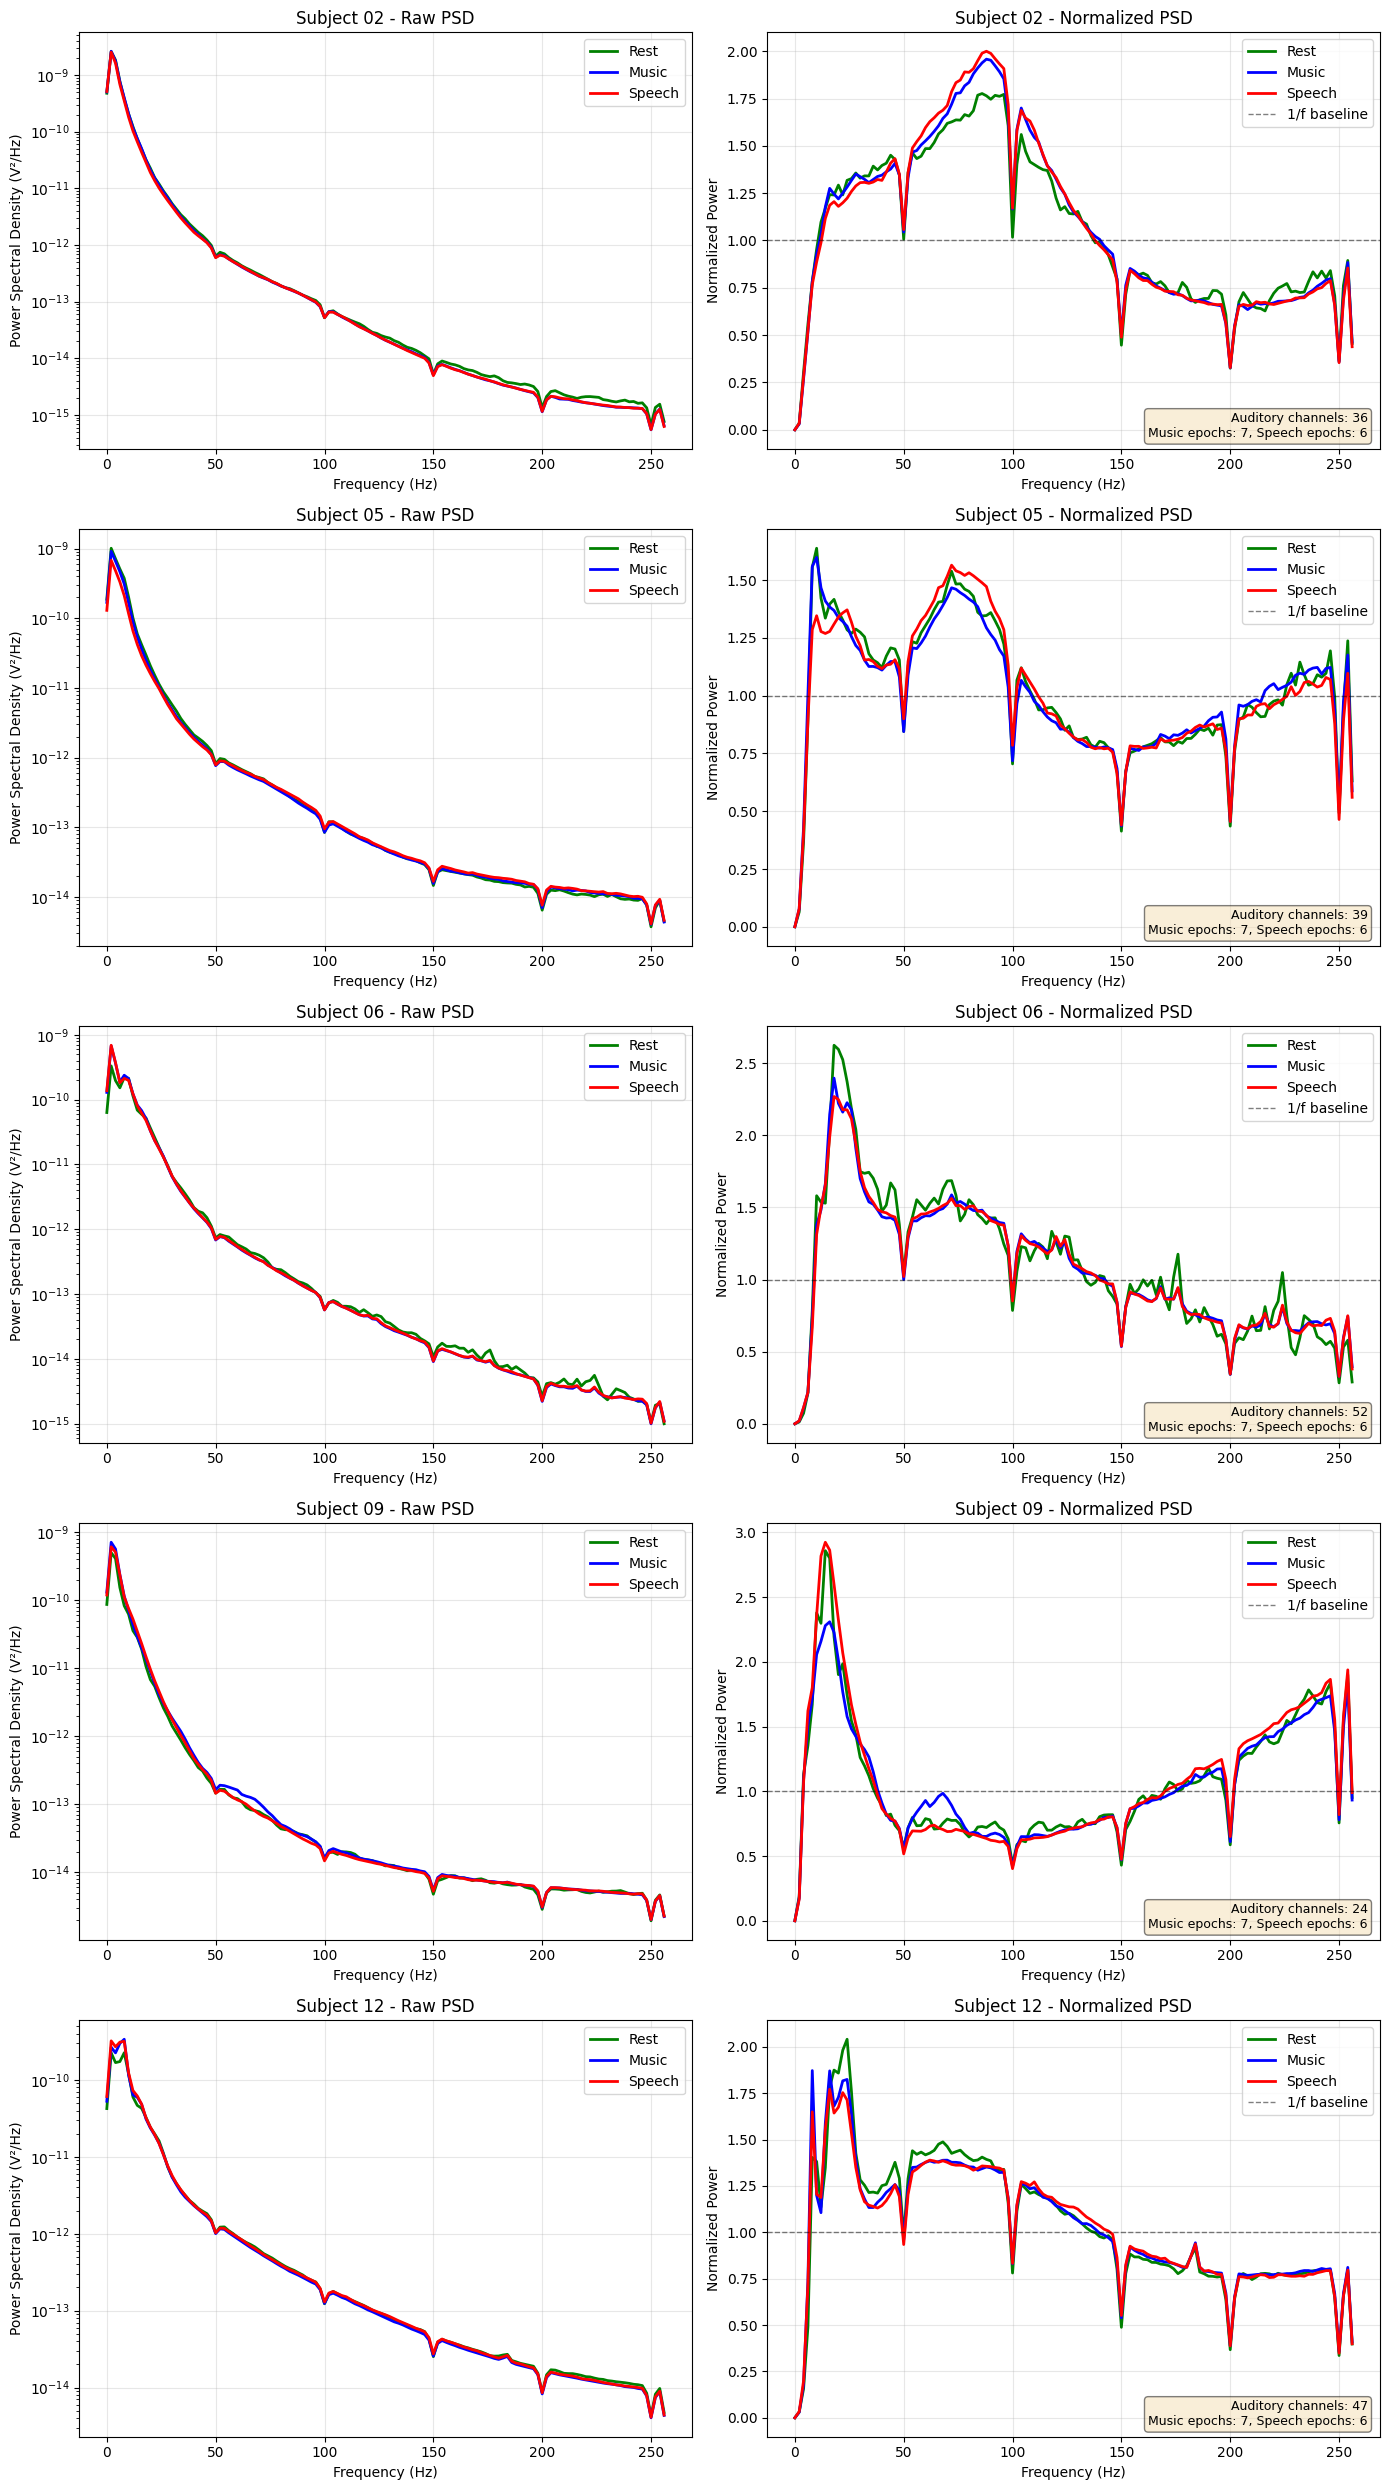

Plotted data for 5 subjects: ['02', '05', '06', '09', '12']


In [134]:
# Load the saved data
with open(f'{processed_data_dir}/normalized_psd_data.pkl', 'rb') as f:
    subjects_psd_data = pickle.load(f)

# Create a figure with subplots for all subjects (2 columns instead of 3)
n_subjects = len(subjects_psd_data)
fig, axes = plt.subplots(n_subjects, 2, figsize=(14, 5 * n_subjects))

# If only one subject, make axes 2D
if n_subjects == 1:
    axes = axes.reshape(1, -1)

for idx, (sub_id, data) in enumerate(subjects_psd_data.items()):
    f = data['frequencies']
    
    # Plot raw PSDs
    axes[idx, 0].semilogy(f, data['rest_psd_raw'], linewidth=2, color='green', label='Rest')
    axes[idx, 0].semilogy(f, data['music_psd_raw'], linewidth=2, color='blue', label='Music')
    axes[idx, 0].semilogy(f, data['speech_psd_raw'], linewidth=2, color='red', label='Speech')
    axes[idx, 0].set_title(f'Subject {sub_id} - Raw PSD', fontsize=12)
    axes[idx, 0].set_xlabel('Frequency (Hz)')
    axes[idx, 0].set_ylabel('Power Spectral Density (V²/Hz)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot normalized PSDs
    axes[idx, 1].plot(f, data['rest_psd_normalized'], linewidth=2, color='green', label='Rest')
    axes[idx, 1].plot(f, data['music_psd_normalized'], linewidth=2, color='blue', label='Music')
    axes[idx, 1].plot(f, data['speech_psd_normalized'], linewidth=2, color='red', label='Speech')
    axes[idx, 1].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
    axes[idx, 1].set_title(f'Subject {sub_id} - Normalized PSD', fontsize=12)
    axes[idx, 1].set_xlabel('Frequency (Hz)')
    axes[idx, 1].set_ylabel('Normalized Power')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add subject info as text
    info_text = f"Auditory channels: {len(data['auditory_channels'])}\n"
    info_text += f"Music epochs: {data['n_music_epochs']}, Speech epochs: {data['n_speech_epochs']}"
    axes[idx, 1].text(0.98, 0.02, info_text, transform=axes[idx, 1].transAxes,
                     fontsize=9, verticalalignment='bottom', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Plotted data for {n_subjects} subjects: {list(subjects_psd_data.keys())}")


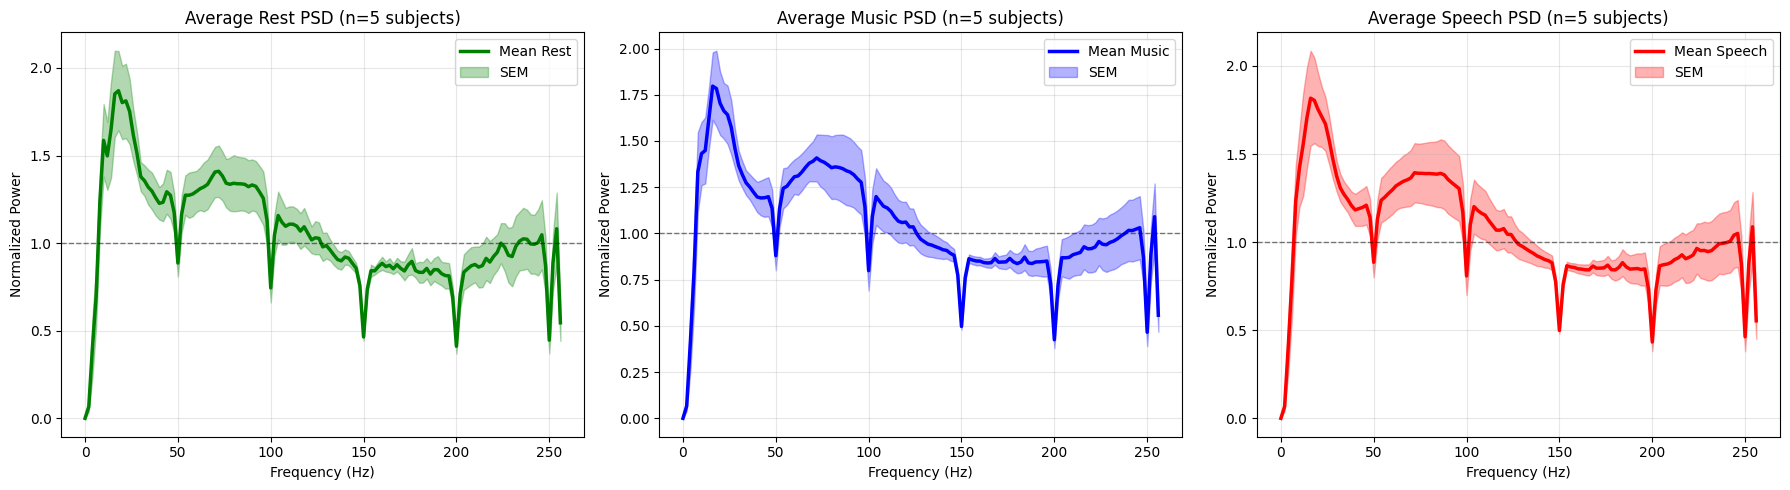

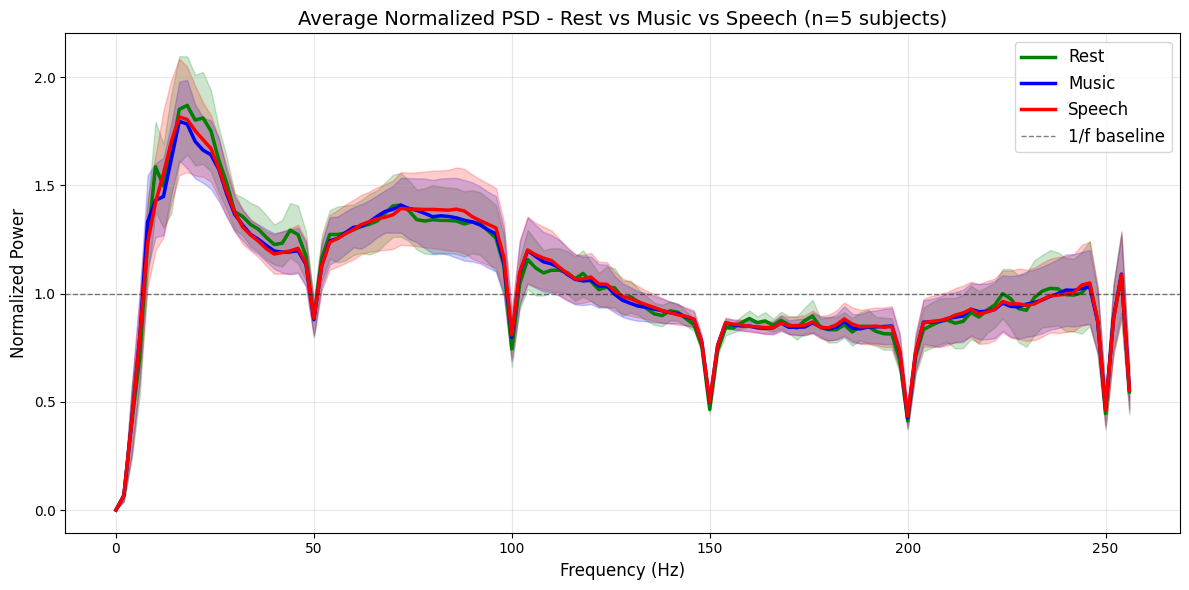

Average PSDs calculated across 5 subjects
Subjects: ['02', '05', '06', '09', '12']


In [135]:
# Calculate average PSDs across all subjects and their SEM
n_subjects = len(subjects_psd_data)

# Initialize arrays to store PSDs for all subjects
all_rest_psd = []
all_music_psd = []
all_speech_psd = []

# Collect PSDs from all subjects
for sub_id, data in subjects_psd_data.items():
    all_rest_psd.append(data['rest_psd_normalized'])
    all_music_psd.append(data['music_psd_normalized'])
    all_speech_psd.append(data['speech_psd_normalized'])

# Convert to numpy arrays
all_rest_psd = np.array(all_rest_psd)
all_music_psd = np.array(all_music_psd)
all_speech_psd = np.array(all_speech_psd)

# Calculate mean and SEM
rest_psd_mean = np.mean(all_rest_psd, axis=0)
music_psd_mean = np.mean(all_music_psd, axis=0)
speech_psd_mean = np.mean(all_speech_psd, axis=0)

rest_psd_sem = np.std(all_rest_psd, axis=0) / np.sqrt(n_subjects)
music_psd_sem = np.std(all_music_psd, axis=0) / np.sqrt(n_subjects)
speech_psd_sem = np.std(all_speech_psd, axis=0) / np.sqrt(n_subjects)

# Use frequency array from first subject (all subjects have same sampling)
f_avg = subjects_psd_data['02']['frequencies']

# Create figure with error clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rest PSD with error cloud
axes[0].plot(f_avg, rest_psd_mean, linewidth=2.5, color='green', label='Mean Rest')
axes[0].fill_between(f_avg, rest_psd_mean - rest_psd_sem, rest_psd_mean + rest_psd_sem, 
                      alpha=0.3, color='green', label='SEM')
axes[0].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[0].set_title(f'Average Rest PSD (n={n_subjects} subjects)', fontsize=12)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Normalized Power')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Music PSD with error cloud
axes[1].plot(f_avg, music_psd_mean, linewidth=2.5, color='blue', label='Mean Music')
axes[1].fill_between(f_avg, music_psd_mean - music_psd_sem, music_psd_mean + music_psd_sem, 
                      alpha=0.3, color='blue', label='SEM')
axes[1].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[1].set_title(f'Average Music PSD (n={n_subjects} subjects)', fontsize=12)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Power')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Speech PSD with error cloud
axes[2].plot(f_avg, speech_psd_mean, linewidth=2.5, color='red', label='Mean Speech')
axes[2].fill_between(f_avg, speech_psd_mean - speech_psd_sem, speech_psd_mean + speech_psd_sem, 
                      alpha=0.3, color='red', label='SEM')
axes[2].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[2].set_title(f'Average Speech PSD (n={n_subjects} subjects)', fontsize=12)
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Normalized Power')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create overlay plot with all three conditions
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(f_avg, rest_psd_mean, linewidth=2.5, color='green', label='Rest')
ax.fill_between(f_avg, rest_psd_mean - rest_psd_sem, rest_psd_mean + rest_psd_sem, 
                alpha=0.2, color='green')

ax.plot(f_avg, music_psd_mean, linewidth=2.5, color='blue', label='Music')
ax.fill_between(f_avg, music_psd_mean - music_psd_sem, music_psd_mean + music_psd_sem, 
                alpha=0.2, color='blue')

ax.plot(f_avg, speech_psd_mean, linewidth=2.5, color='red', label='Speech')
ax.fill_between(f_avg, speech_psd_mean - speech_psd_sem, speech_psd_mean + speech_psd_sem, 
                alpha=0.2, color='red')

ax.axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
ax.set_title(f'Average Normalized PSD - Rest vs Music vs Speech (n={n_subjects} subjects)', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Normalized Power', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average PSDs calculated across {n_subjects} subjects")
print(f"Subjects: {list(subjects_psd_data.keys())}")